In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import torch
import subprocess
import numpy as np
from torchmetrics import PrecisionRecallCurve, F1Score, ConfusionMatrix, Precision, Recall
from typing import List, Any
from torcheval.metrics.functional import binary_auprc, binary_auroc
from collections import defaultdict
import torch.nn as nn

/home/free4ky/projects/chest-diseases/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(
            self,
            input_size=512,
            num_classes=18,
            activation='relu',
            hidden_sizes=[1024, 2048, 1024, 256, 128],
            dropout=0.1
        ):
        super().__init__()
        
        # Pick activation
        if activation == "relu":
            activation_cls = nn.ReLU
        elif activation == "leaky_relu":
            activation_cls = nn.LeakyReLU
        elif activation == "gelu":
            activation_cls = nn.GELU
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        layers = []
        in_dim = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))  # helps stabilize
            layers.append(activation_cls())
            layers.append(nn.Dropout(dropout))
            in_dim = h

        # Final classification layer
        layers.append(nn.Linear(in_dim, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)
    
model = MLP(
    input_size=512,
    activation='leaky_relu',
    dropout=0.1,
    num_classes=2,
)

In [3]:
state_dict = torch.load('model_binary.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
from  torch.utils.data import TensorDataset, DataLoader
val_ds = TensorDataset(
        torch.load('/home/free4ky/projects/chest-diseases/data/preprocessed_val/validation_data.pt'),
        torch.load('/home/free4ky/projects/chest-diseases/data/preprocessed_val/validation_labels.pt')
)
val_dl = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False
)


In [5]:
model.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2048, bias=True)
    (5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=1024, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=256

In [6]:
patalogy_probs = []
with torch.no_grad():
    for emb, labels in val_dl:
        label = labels.any(dim=-1).long()
        emb = torch.nn.functional.normalize(emb)
        logits = model(emb)
        probs = nn.functional.softmax(logits)
        patalogy_probs.append(probs[0][-1].cpu().item())
patalogy_probs

/tmp/ipykernel_73168/2955114851.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = nn.functional.softmax(logits)


[0.820165753364563,
 0.8043804168701172,
 0.8602136969566345,
 0.8702327013015747,
 0.7959941029548645,
 0.7996436953544617,
 0.7352612018585205,
 0.8368420004844666,
 0.8320521116256714,
 0.7556499242782593,
 0.8317095041275024,
 0.7416245937347412,
 0.7370414733886719,
 0.8117664456367493,
 0.7981765270233154,
 0.7742293477058411,
 0.7891433238983154,
 0.6954633593559265,
 0.8437573909759521,
 0.8661475777626038,
 0.7698612213134766,
 0.8181803822517395,
 0.7825255393981934,
 0.8050835132598877,
 0.7816381454467773,
 0.8371039628982544,
 0.9170058369636536,
 0.9056314826011658,
 0.7543417811393738,
 0.7589829564094543,
 0.40425506234169006,
 0.4199453890323639,
 0.8736680746078491,
 0.8566257357597351,
 0.5575169920921326,
 0.6334088444709778,
 0.8348577618598938,
 0.8158189654350281,
 0.9048213958740234,
 0.9012160301208496,
 0.8807200789451599,
 0.9127769470214844,
 0.9057803153991699,
 0.8889264464378357,
 0.803643524646759,
 0.8146321177482605,
 0.7395116090774536,
 0.72697085142

## Instatiate metrics

In [7]:
num_classes = 2
f1_scorer = F1Score(task='binary', num_classes=num_classes, average='macro')
precision_scorer = Precision(task='binary', num_classes=num_classes, average='macro')
recall_scorer = Recall(task='binary', num_classes=num_classes, average='macro')
pr_curve = PrecisionRecallCurve(task='binary')
confusion_matrix = ConfusionMatrix(task='binary', num_classes=num_classes)

In [8]:
f1 = f1_scorer(torch.tensor(patalogy_probs), val_ds.tensors[-1].any(dim=-1).long())
f1

tensor(0.9333)

In [9]:
data = defaultdict(list)
precisions, recalls, thresholds = pr_curve(
        torch.tensor(patalogy_probs),
        val_ds.tensors[-1].any(dim=-1).long()
)
data['precision'].extend(precisions[:-1].tolist())
data['recall'].extend(recalls[:-1].tolist())
data['threshold'].extend(thresholds.tolist())
data['model'].extend(['binary'] * len(thresholds))

In [10]:
def make_line_plot(x:List[Any], y:List[Any], x_label:str, y_label:str, plot_name:str,label, color) -> None:
    sns.lineplot(x=x, y=y, label=label,color=color)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [11]:
df = pd.DataFrame(data)

In [12]:
df

,precision,recall,threshold,model
0,0.886147,1.000000,0.179534,binary
1,0.886109,0.999629,0.218035,binary
2,0.886072,0.999257,0.230644,binary
3,0.886034,0.998886,0.241252,binary
4,0.886326,0.998886,0.284833,binary
...,...,...,...,...
3034,0.600000,0.001114,0.966831,binary
3035,0.750000,0.001114,0.969926,binary
3036,1.000000,0.001114,0.975718,binary
3037,1.000000,0.000743,0.977661,binary


In [13]:
df

,precision,recall,threshold,model
0,0.886147,1.000000,0.179534,binary
1,0.886109,0.999629,0.218035,binary
2,0.886072,0.999257,0.230644,binary
3,0.886034,0.998886,0.241252,binary
4,0.886326,0.998886,0.284833,binary
...,...,...,...,...
3034,0.600000,0.001114,0.966831,binary
3035,0.750000,0.001114,0.969926,binary
3036,1.000000,0.001114,0.975718,binary
3037,1.000000,0.000743,0.977661,binary


In [14]:
# colors = ['orange', 'blue', 'green', 'red', 'black', 'magenta', 'chocolate', 'crimson', 'gold']
# versions = ['v4', 'v3', 'v8', 'v9']
# colors = ['black', 'red', 'gold', 'green']
versions = ['binary']
colors = ['green']

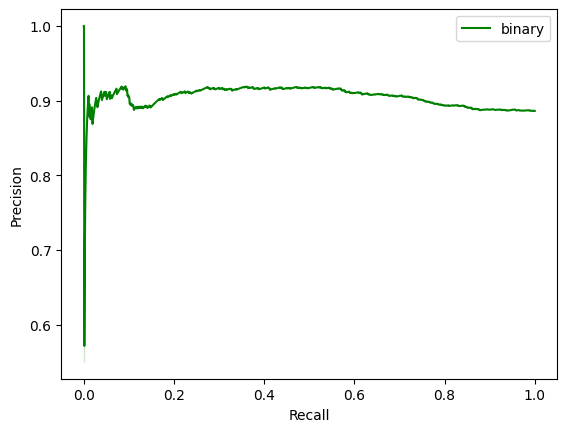

In [15]:
for v, c in zip(versions, colors):
    make_line_plot(df[df.model==v].recall, df[df.model==v].precision, 'Recall', 'Precision', 'Precisoin/Recall', v, color=c)

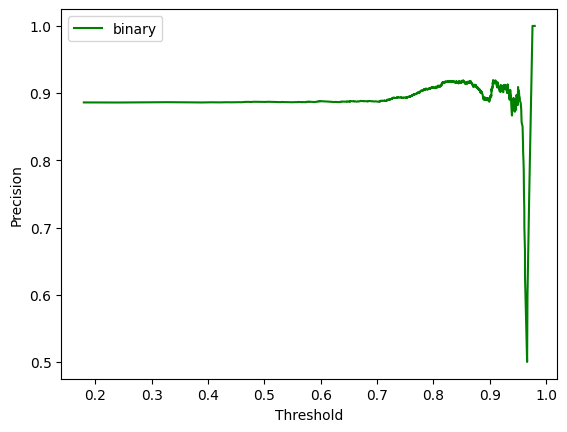

In [16]:
for v, c in zip(versions, colors):
    make_line_plot(df[df.model==v].threshold, df[df.model==v].precision, 'Threshold', 'Precision', 'Precisoin/Threshold', v, c)

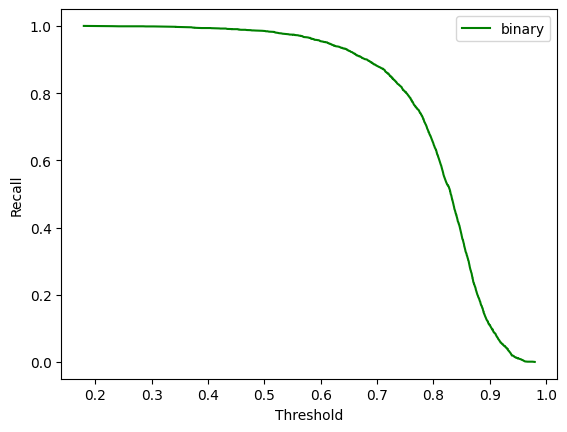

In [17]:
for v, c in zip(versions, colors):
    make_line_plot(df[df.model==v].threshold, df[df.model==v].recall, 'Threshold', 'Recall', 'Precisoin/Threshold', v, c)

In [18]:
df['f1'] = df.apply(lambda x: (2 * x.precision * x.recall) / (x.precision + x.recall), axis=1)

In [19]:
# versions = ['v4', 'v3', 'v8']
# colors = ['black', 'red', 'gold']

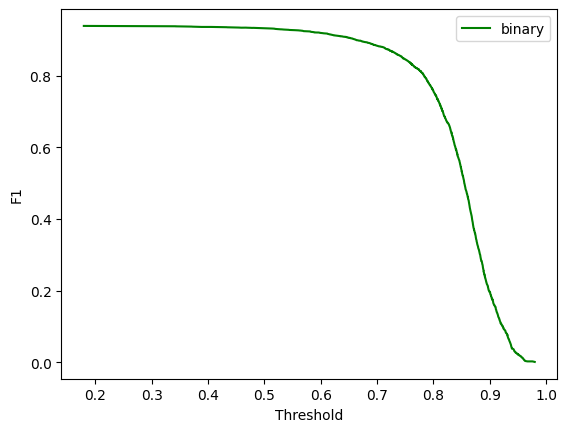

In [20]:
for v, c in zip(versions, colors):
    make_line_plot(df[df.model==v].threshold, df[df.model==v].f1, 'Threshold', 'F1', 'F1/Threshold', v, c)
# v8 - avito6000 (validated by me) + Steve dataset + yandex images
# v5 - avito6000 (validated by me) + Steve dataset
# v4 - avito6000 + action_reason60 + Steve dataeset

In [21]:
# old_model_df = df.loc[(df.model == 'old_model') & (abs(df.threshold - 0.8) < 0.005)]
# old_model_df.iloc[1]

In [22]:
grouped = df.groupby(['model']).agg({'f1':max})

/tmp/ipykernel_73168/1929570015.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped = df.groupby(['model']).agg({'f1':max})


In [23]:
grouped

,f1
model,
binary,0.939637


In [24]:
stats = df.loc[df.f1.isin(grouped.f1)]

In [26]:
stats

,precision,recall,threshold,model,f1
0,0.886147,1.0,0.179534,binary,0.939637


In [27]:
# stats.sort_values(by='f1', ascending=True)
stats = stats.drop_duplicates(subset='f1')

In [28]:
stats['auprc'] = [None] * len(stats)

In [29]:
# dfs = [dfs[-2], dfs[-1]]
for v in versions:
    bauprc = binary_auprc(torch.tensor(patalogy_probs), val_ds.tensors[-1].any(dim=-1).long())
    idx = stats.loc[stats.model == v].index
    stats.loc[idx, 'auprc'] = bauprc

In [30]:
stats

,precision,recall,threshold,model,f1,auprc
0,0.886147,1.0,0.179534,binary,0.939637,0.904267


In [31]:
stats['auroc'] = [None] * len(stats)
for v in versions:
    bauprc = binary_auroc(torch.tensor(patalogy_probs), val_ds.tensors[-1].any(dim=-1).long())
    idx = stats.loc[stats.model == v].index
    stats.loc[idx, 'auroc'] = bauprc

In [32]:
stats

,precision,recall,threshold,model,f1,auprc,auroc
0,0.886147,1.0,0.179534,binary,0.939637,0.904267,0.576858


In [31]:
q1_stats = stats[stats.model.isin(['v9', 'v10'])]

In [32]:
q1_stats

,precision,recall,threshold,model,f1,auprc
78140,0.889286,0.841216,0.765189,v9,0.864583,0.884107
86011,0.912548,0.810811,0.796447,v10,0.858676,0.88697


In [39]:
q1_stats.loc[len(q1_stats.index)] = [*old_model_df.iloc[1].tolist(), 0.774169]
q1_stats

/tmp/ipykernel_602660/425377504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  q1_stats.loc[len(q1_stats.index)] = [*old_model_df.iloc[1].tolist(), 0.774169]


,precision,recall,threshold,model,f1,auprc
78140,0.889286,0.841216,0.765189,v9,0.864583,0.884107
93805,0.701258,0.753378,0.848627,old_model,0.726384,0.774169
2,0.575243,0.800676,0.801067,old_model,0.669492,0.774169


/tmp/ipykernel_6120/1297851725.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_ds.tensors[-1].any(dim=-1).long())
/tmp/ipykernel_6120/1297851725.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_ds.tensors[-1].any(dim=-1).long())


(tensor([[  68,  278],
         [ 134, 2559]]),)

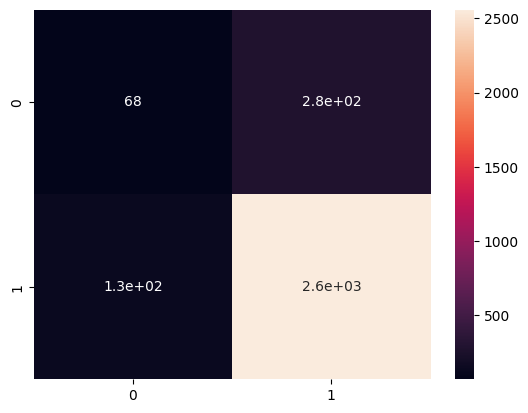

In [74]:
preds = (pd.Series(patalogy_probs) > 0.5).apply(lambda x: int(x)).tolist()
sns.heatmap(
    confusion_matrix(
        torch.tensor(preds),
        torch.tensor(val_ds.tensors[-1].any(dim=-1).long())
    ),
    annot=True,
);
confusion_matrix(
        torch.tensor(preds),
        torch.tensor(val_ds.tensors[-1].any(dim=-1).long())
    ),

/tmp/ipykernel_6120/132539993.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_ds.tensors[-1].any(dim=-1).long())


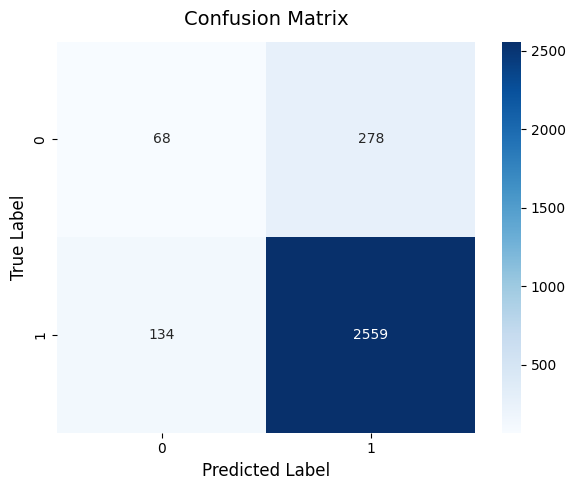

In [77]:
# Plot with Seaborn
preds = (pd.Series(patalogy_probs) > 0.5).apply(lambda x: int(x)).tolist()

plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(
        torch.tensor(preds),
        torch.tensor(val_ds.tensors[-1].any(dim=-1).long())
    ),
    annot=True,
    fmt="d",
    cmap="Blues",

)
plt.title("Confusion Matrix", fontsize=14, pad=12)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
val_ds.tensors[-1].any(dim=-1).long()

tensor(2693)

In [22]:
sum(preds)

2018

In [19]:
df['pred'] = preds

In [20]:
df

,prob_nsfw,label,start,end,path,pred
0,0.004083,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
1,0.001042,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
2,0.000094,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
3,0.131818,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
4,0.000154,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
...,...,...,...,...,...,...
9466,0.003538,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
9467,0.899589,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
9468,0.001970,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
9469,0.013016,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0


In [21]:
df[df.pred != df.label]

,prob_nsfw,label,start,end,path,pred
62,0.977373,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
171,0.139308,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
193,0.933047,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
325,0.835838,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
432,0.900618,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
...,...,...,...,...,...,...
9124,0.962186,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,1
9131,0.739292,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
9212,0.385076,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0
9374,0.233058,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...,0


In [55]:
df[df.pred != df.label].iloc[14]

prob_nsfw                                             0.021036
label                                                        1
start                                                 00:00:06
end                                                   00:00:36
path         /data/dkarpov/datasets/datasets/auto_0105_3105...
pred                                                         0
Name: 1119, dtype: object

In [58]:
df[df.pred != df.label].to_excel('Errors.xlsx', index=False)

In [24]:
df2 = dfs[-1]
df1 = dfs[-2]

In [31]:
df.iloc[df[df.model=='v1'].f1.idxmax()]

precision    0.847328
recall           0.75
threshold    0.796286
model              v1
f1           0.795699
Name: 15465, dtype: object

In [32]:
preds2 = (df2.prob_nsfw > 0.911586).apply(lambda x: int(x)).tolist()
preds1 = (df1.prob_nsfw > 0.796286).apply(lambda x: int(x)).tolist()

In [40]:
set(df1[df1.label != preds1].path).difference(set(df2[df2.label != preds2].path))

{'/data/dkarpov/datasets/datasets/auto_0105_3105_tech/00436.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/00768.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01026.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01069.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01155.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01238.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01528.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01763.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01839.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/01869.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/02361.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/02430.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/02756.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/02983.mp4',
 '/data/dkarpov/datasets/datasets/auto_0105_3105_tech/03307.mp4',
 '/data/dk

In [34]:
df2[df2.label != preds2]

,prob_nsfw,label,start,end,path
59,0.896928,1,00:00:02,00:00:32,/data/dkarpov/datasets/datasets/auto_0105_3105...
62,0.989472,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
140,0.752706,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
171,0.861236,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
188,0.911866,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
...,...,...,...,...,...
9131,0.701042,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
9212,0.816331,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
9374,0.740141,1,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...
9463,0.913334,0,00:00:01,00:00:31,/data/dkarpov/datasets/datasets/auto_0105_3105...


## Calculate 9.5k video duration

In [6]:
from pathlib import Path
from tqdm import tqdm

In [2]:
command = 'ffprobe -v error -show_entries format=duration -of default=noprint_wrappers=1:nokey=1 {sourse}'

In [4]:
files = list(Path('/data/dkarpov/datasets/datasets/auto_0105_3105_tech').rglob('*.mp4'))

In [5]:
len(files)

9471

In [17]:
durations = []
for f in tqdm(files):
    durations.append(float(subprocess.run(command.format(sourse=f), shell=True, stdout=subprocess.PIPE).stdout.decode().strip()))

100%|██████████| 9471/9471 [09:13<00:00, 17.12it/s]


In [18]:
durations

[18.0,
 44.0,
 4.0,
 5.0,
 247.0,
 18.0,
 45.0,
 7.0,
 5.0,
 30.0,
 33.0,
 12.0,
 188.0,
 40.0,
 45.0,
 43.0,
 16.0,
 8.0,
 9.0,
 82.0,
 9.0,
 46.0,
 17.0,
 2.0,
 12.0,
 66.0,
 15.0,
 68.0,
 86.0,
 14.0,
 10.0,
 185.0,
 63.0,
 17.0,
 24.0,
 13.0,
 9.0,
 28.0,
 83.0,
 33.0,
 17.0,
 33.0,
 13.0,
 43.0,
 9.0,
 40.0,
 47.0,
 94.0,
 87.0,
 30.0,
 8.0,
 7.0,
 7.0,
 51.0,
 22.0,
 7.0,
 39.0,
 12.0,
 172.0,
 10.0,
 16.0,
 15.0,
 12.0,
 26.0,
 93.0,
 46.0,
 6.0,
 39.0,
 5.0,
 25.0,
 8.0,
 47.0,
 16.0,
 9.0,
 31.0,
 8.0,
 35.0,
 24.0,
 52.0,
 17.0,
 27.0,
 18.0,
 39.0,
 104.0,
 46.0,
 23.0,
 23.0,
 31.0,
 8.0,
 13.0,
 22.0,
 18.0,
 15.0,
 9.0,
 56.0,
 38.0,
 26.0,
 21.0,
 113.0,
 40.0,
 13.0,
 6.0,
 173.0,
 29.0,
 13.0,
 52.0,
 32.0,
 64.0,
 5.0,
 6.0,
 124.0,
 11.0,
 105.0,
 47.0,
 41.0,
 43.0,
 21.0,
 26.0,
 9.0,
 31.0,
 75.0,
 12.0,
 14.0,
 238.0,
 59.0,
 55.0,
 6.0,
 86.0,
 37.0,
 12.0,
 8.0,
 7.0,
 17.0,
 20.0,
 72.0,
 89.0,
 14.0,
 59.0,
 5.0,
 5.0,
 7.0,
 31.0,
 83.0,
 93.0,
 72.0,
 9.0,


In [19]:
sum(durations)

369716.675

In [31]:
file_duration_map = pd.DataFrame(data={'path':files, 'duration':durations})

In [33]:
file_duration_map.to_csv('../data/datasets/file_duration_map.csv', index=False)

## Compare probability distribution of two models

hard cases - kiss, hug, dialogue, bed scenes

v9 - before learning hard cases

v10 - after learning hard cases

In [3]:
v10_df = pd.read_csv('/data/dkarpov/projects/ml-videomoder/outputs/2024-04-09/11-23-52/run.csv')
v9_df = pd.read_csv('/data/dkarpov/projects/ml-videomoder/outputs/2024-04-09/12-31-07/run.csv')

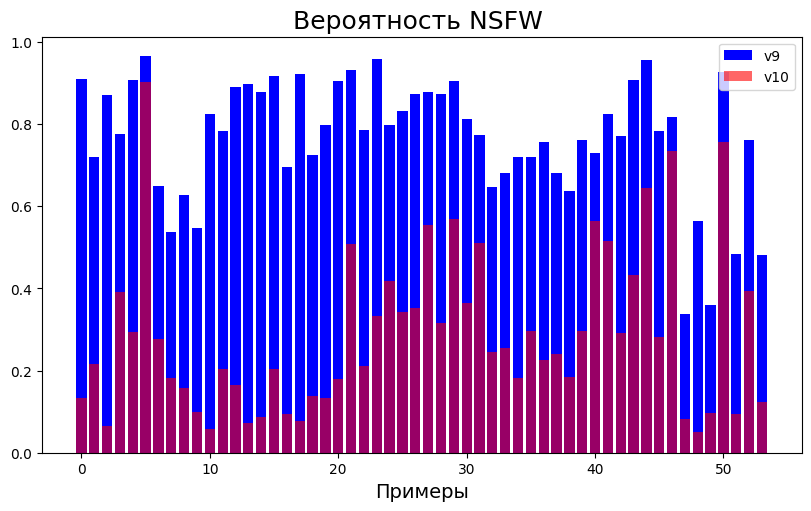

In [8]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(8, 5), layout='constrained')
# ax.plot(x, pd.unique(y1), label='Модель v.01', color='blue', linewidth=3)  # Plot some data on the axes.
ax.bar(x=v9_df.index, height=v9_df.prob_nsfw, alpha=1, color='blue', label='v9')  # Plot more data on the axes...
ax.bar(x=v10_df.index, height=v10_df.prob_nsfw, alpha=0.6, color='red', label='v10')
ax.set_xlabel('Примеры', fontdict={'fontsize': 14})  # Add an x-label to the axes.
ax.set_title("Вероятность NSFW ", fontdict={'fontsize': 18})  # Add a title to the axes.
# ax.((16,16))
ax.legend(loc='upper right')  # Add a legend.
plt.savefig('nsfw_prob_v9_vs_v10.png')

In [10]:
v9_df.prob_nsfw.mean()

0.7676714542839262

In [11]:
v10_df.prob_nsfw.mean()

0.2885202136304643

In [33]:
import torch

torch.load('/home/free4ky/projects/chest-diseases/data/preprocessed_train_20/train_labels.pt').shape

torch.Size([42431, 20])

In [ ]:

torch.load('/home/free4ky/projects/chest-diseases/data/preprocessed_train_20/_labels.pt').shape

torch.Size([4715, 20])

: 